## Demo file for the SNax code 

This Notebook demonstrates as few capabilities of the [`SNax`](https://github.com/sebhoof/snax) library.
Before running the file, you need to install the C++ and Python libraries using CMAKE.
This can be done via running the line `mkdir build; cd build; cmake ..; make` from the repo.

In [1]:
# Import the required packages
import sys, os
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad

script_dir = os.path.dirname(os.path.realpath("__file__"))
sys.path.append(os.path.abspath(script_dir+"/code/lib/"))
sys.path.append(os.path.abspath(script_dir+"/code/python/"))

import pysnax as sn
from pysnax import constants as cnst

from physics import spectrum_payez
from stats import a_eff, sigma
from alp_decay import compute_decay_photon_fluence
from alp_conversion import compute_alp_conversion_photon_fluence

### Axion spectra and other inputs

The cells below explore some of the constants available from the `pysnax` module.

In [2]:
# Investigate the constants used in the code
print("Available keys:", [key for key in cnst])
print("Distance to SN1987A: {:.3e} m".format(sn.constants['d']))

Available keys: ['alpha', 'hbar', 'c', 'hbarc', 'pc', 'd', 'distance_factor', 'renv', 'ks2_payez15', 't_eff_payez15', 'snorm_payez15', 'ks2_jaeckel17', 't_eff_jaeckel17', 'snorm_jaeckel17']
Distance to SN1987A: 1.586e+21 m


Now integrate the time-dependent spectrum from [Payez+ '15](https://arxiv.org/abs/1410.3747) and compare to [Jaeckel+ '17](https://arxiv.org/abs/1702.02964).

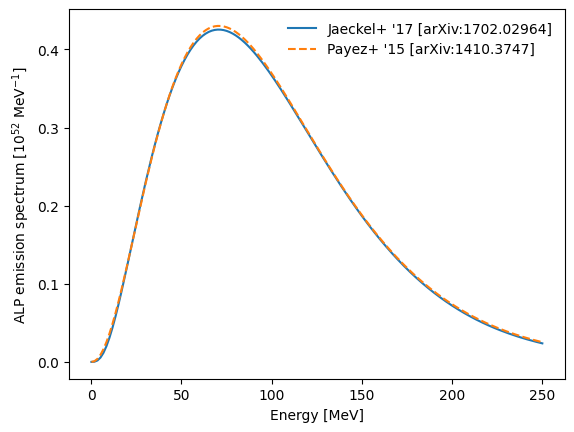

In [3]:
# Define ALP mass and coupling, and some energy values for plotting
m0 = 0
g0 = 1e-19 # eV^-1
evals = np.linspace(0.1, 250, 151)*1e6 # eV

# Integrate the time-dependent spectrum from Payez+ '15 for the full available time interval of [0.005, 18] s.
# integrand = lambda ea: quad(lambda t: sn.temporal_spectrum(m0, g0, ea, t, cnst.snorm_payez15, "e0"_a, "p"_a, cnst.ks2_payez15))[0]
sp_payez = np.array([quad(lambda ta: spectrum_payez(m0, g0, e, ta), 5e-3, 18)[0] for e in evals])

# Compare with Jaeckel+ '17
sp_jaeckel = np.array([sn.spectrum0(g0, e) for e in evals])

plt.plot(evals/1e6, sp_jaeckel/1e46, label=r"Jaeckel+ '17 [arXiv:1702.02964]")
plt.plot(evals/1e6, sp_payez/1e46, ls='--', label=r"Payez+ '15 [arXiv:1410.3747]")
plt.ylabel(r"ALP emission spectrum [$10^{52}$ MeV$^{-1}$]")
plt.xlabel(r"Energy [MeV]")
plt.legend(frameon=False)
plt.show()

### Signal predicton of ALP decays into photons

Compute the fluence for decaying heavy ALPs changes as we vary the coupling.
This can be done with our updated integral expression from Eq. (2.8) in [[arXiv:2212.09764]](https://arxiv.org/abs/2212.09764).

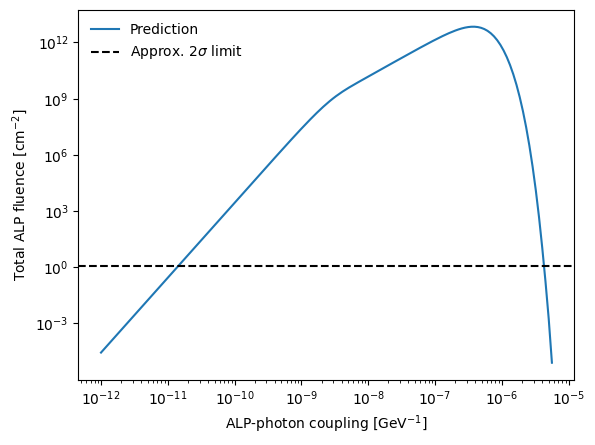

In [4]:
# Define the ALP mass and some coupling values
m0 = 1e6 # eV
gvals = np.logspace(-21, -14.25, 141) # eV^-1
# Define an energy range and (possibly many) time bins
ebin0 = [25e6, 100e6] # eV
tbin0 = [0, 223.232] # s

# Compute the resulting fluence (using the instantaneous emission spectrum from Payez+ '15)
alp_fluence = np.array([compute_decay_photon_fluence(m0, g, ebin0, tbin0)[0] for g in gvals])

plt.plot(gvals*1e9, alp_fluence, label=r"Prediction")
plt.gca().axhline(2*sigma, c='k', ls='--', label=r"Approx. $2\sigma$ limit")
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"Total ALP fluence [cm$^{-2}$]")
plt.xlabel(r"ALP-photon coupling [GeV$^{-1}$]")
plt.legend(frameon=False)
plt.show()

### Signal predicton of ALP conversions into photons

Compute the fluence for light ALPs converting into photon as we vary their mass.
This uses the external `gammaALPs` Python code, available e.g. via `pip`.

Note the time-dependence of the signal, which allowed us to improve the ALP limits in this region by a factor of 1.4 in in [[arXiv:2212.09764]](https://arxiv.org/abs/2212.09764).

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")


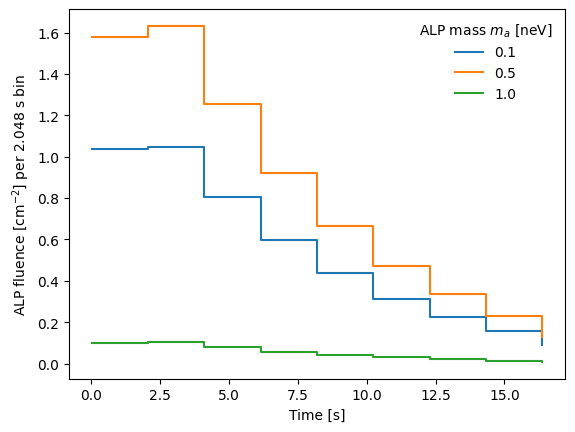

In [5]:
ebin0 = [25e6, 100e6] # eV
tbins0 = [max(0.005, min(2.048*i, 18.0)) for i in range(10)] # s
g0 = 1e-20 # eV^-1
mvals = [1e-10, 5e-10, 1e-9] # eV

# Compute the resulting fluence (using the time-dependent emission spectrum from Payez+ '15)
alp_counts = [compute_alp_conversion_photon_fluence(m, g0, ebin0, tbins0) for m in mvals]

for line, m in zip(alp_counts, mvals):
   plt.step(tbins0[:-1], line, where='post', label=r"{:.1f}".format(m/1e-9))
plt.ylabel(r"ALP fluence [cm$^{-2}$] per 2.048 s bin")
plt.xlabel(r"Time [s]")
plt.legend(frameon=False, title=r"ALP mass $m_a$ [neV]")
plt.show()